# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style='whitegrid', palette='Paired')
import matplotlib.pyplot as plt
%matplotlib inline

# **Load and Inspect the Label Data**

In [2]:
train_df = pd.read_csv("training_labels.csv")
test_df = pd.read_csv("testing_labels.csv")
print("Training shape:", train_df.shape)
print("Testing shape:", test_df.shape)

print(train_df.head())

Training shape: (413, 4)
Testing shape: (103, 4)
  Image name  Retinopathy grade  Risk of macular edema  Retinopathy
0  IDRiD_001                  3                      2            1
1  IDRiD_002                  3                      2            1
2  IDRiD_003                  2                      2            1
3  IDRiD_004                  3                      2            1
4  IDRiD_005                  4                      0            1


There are 413 training images and 103 testing images which is approximately an 80/20 split

# **Retinopathy Distribution**

<ipython-input-40-410775689>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=train_df, x='Retinopathy', palette='Blues')
<ipython-input-40-410775689>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=test_df, x='Retinopathy', palette='Greens')


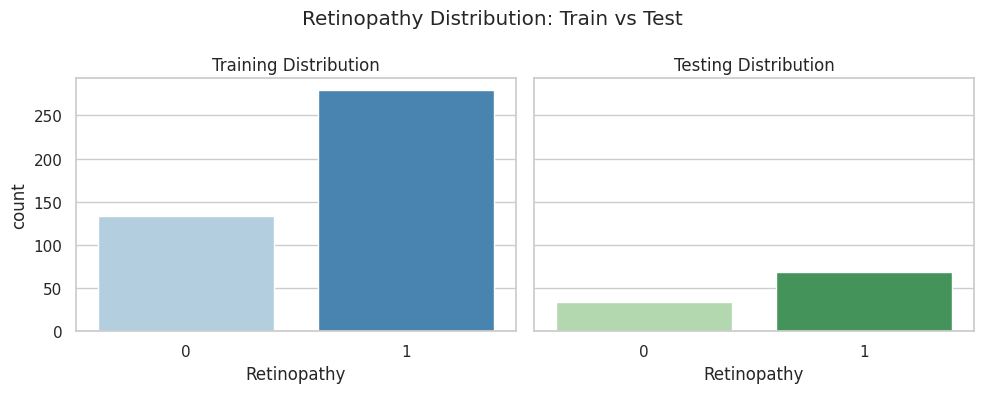

Training Distribution: Retinopathy
1    0.675545
0    0.324455
Name: proportion, dtype: float64 

Testing Distribution: Retinopathy
1    0.669903
0    0.330097
Name: proportion, dtype: float64


In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot training and testing distribution
sns.countplot(ax=axes[0], data=train_df, x='Retinopathy', palette='Blues')
axes[0].set_title('Training Distribution')
sns.countplot(ax=axes[1], data=test_df, x='Retinopathy', palette='Greens')
axes[1].set_title('Testing Distribution')

plt.suptitle('Retinopathy Distribution: Train vs Test')
plt.tight_layout()
plt.show()

print("Training Distribution:", train_df['Retinopathy'].value_counts(1), "\n")
print("Testing Distribution:", test_df['Retinopathy'].value_counts(1))

Unfortunately, there is a moderate class imbalance in both sets. The positive class ("DR") has nearly double the representation compared to the negative class ("No DR"). This might cause our image classification models to overfit to the positive class and predict the presence of DR more often.

# **Retinopathy Grade Distribution**

<ipython-input-41-3924553906>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=train_df, x='Retinopathy grade', palette='Blues')
<ipython-input-41-3924553906>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=test_df, x='Retinopathy grade', palette='Greens')


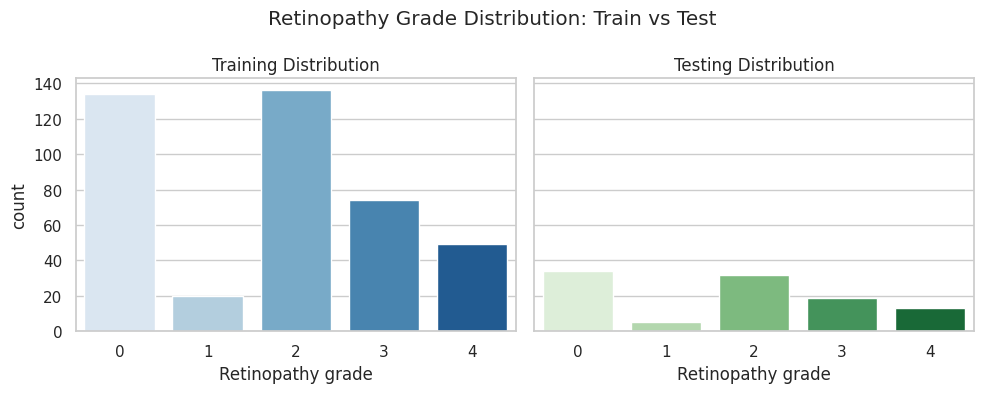

Training Distribution: Retinopathy grade
2    0.329298
0    0.324455
3    0.179177
4    0.118644
1    0.048426
Name: proportion, dtype: float64 

Testing Distribution: Retinopathy grade
0    0.330097
2    0.310680
3    0.184466
4    0.126214
1    0.048544
Name: proportion, dtype: float64


In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot training and testing distribution
sns.countplot(ax=axes[0], data=train_df, x='Retinopathy grade', palette='Blues')
axes[0].set_title('Training Distribution')
sns.countplot(ax=axes[1], data=test_df, x='Retinopathy grade', palette='Greens')
axes[1].set_title('Testing Distribution')

plt.suptitle('Retinopathy Grade Distribution: Train vs Test')
plt.tight_layout()
plt.show()

print("Training Distribution:", train_df['Retinopathy grade'].value_counts(1), "\n")
print("Testing Distribution:", test_df['Retinopathy grade'].value_counts(1))

In [5]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset

This class inherits PyTorch's Dataset utility class to load the retinal images from the image directory and their corresponding binary Retinopathy label from the labels CSV file. The class also applies an optional transform pipeline. Lastly, the class returns the image tensor and label tensor.

In [6]:
class DRDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels_df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        #First column contains image names
        img_name = self.labels_df.iloc[idx, 0]

        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')

        # Get binary label from "Retinopathy" column
        label = self.labels_df.iloc[idx, -1]
        label = torch.tensor(label, dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

# **Custom Transformation Classes**

**1. Contrast Limited Adaptive Histogram Equalization (CLAHE)**



*   Minimizes noise in retinal images by enhancing the contrast and brightness
*   Enhances the green channel, which typically contains the most retinal detail (highlights blood vessels more clearly)


**2. Retinal Center Crop**



*   Creates a circular mask to isolate the central circular retinal region
*   Removes irrelevant corners in the image



In [7]:
from PIL import Image, ImageOps, ImageEnhance

class SimpleCLAHE:
    """A simplified version of CLAHE using PIL"""
    def __init__(self, clip_limit=2.0):
        self.clip_limit = clip_limit

    def __call__(self, img):
        # Enhance contrast and brightness
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(1.5)  # Boost contrast

        # Enhance green channel for retinal images
        r, g, b = img.split()
        g_enhanced = ImageEnhance.Contrast(g).enhance(1.8)

        # Recombine with enhanced green channel
        return Image.merge("RGB", (r, g_enhanced, b))

class RetinalCenterCrop:
    """Crop to the center circular region of retinal images"""
    def __call__(self, img):
        # Create a circular mask
        mask = Image.new('L', img.size, 0)
        width, height = img.size
        center = (width//2, height//2)
        radius = min(width, height)//2

        # Circular mask
        from PIL import ImageDraw
        draw = ImageDraw.Draw(mask)
        draw.ellipse((center[0]-radius, center[1]-radius,
                      center[0]+radius, center[1]+radius), fill=255)

        # Apply the mask
        result = img.copy()
        result.putalpha(mask)

        # Create a background of average color
        bg_color = tuple(map(int, np.array(img).mean(axis=(0,1))))
        bg = Image.new('RGB', img.size, bg_color)

        # Paste the masked image onto the background
        bg.paste(result, (0, 0), mask)
        return bg

# **Training/Testing Transformation Pipeline**

In [8]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    RetinalCenterCrop(),
    SimpleCLAHE(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.2, 0.2, 0.2])
])

test_transform = transforms.Compose([
    # RetinalCenterCrop(),
    # SimpleCLAHE(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.2, 0.2, 0.2])
])

# **Load and Pre-Process the Training Set**

Using the custom DRDataset, we'll load the training set and apply the training transformation pipeline.

In [12]:
TRAIN_IMAGES_DIR = 'training_images'
TRAIN_LABELS_DIR = 'training_labels.csv'

full_dataset = DRDataset(
        img_dir=TRAIN_IMAGES_DIR,
        csv_file=TRAIN_LABELS_DIR,
        transform=train_transform
    )

# **Visualize Training Images: Before and After Transformation**

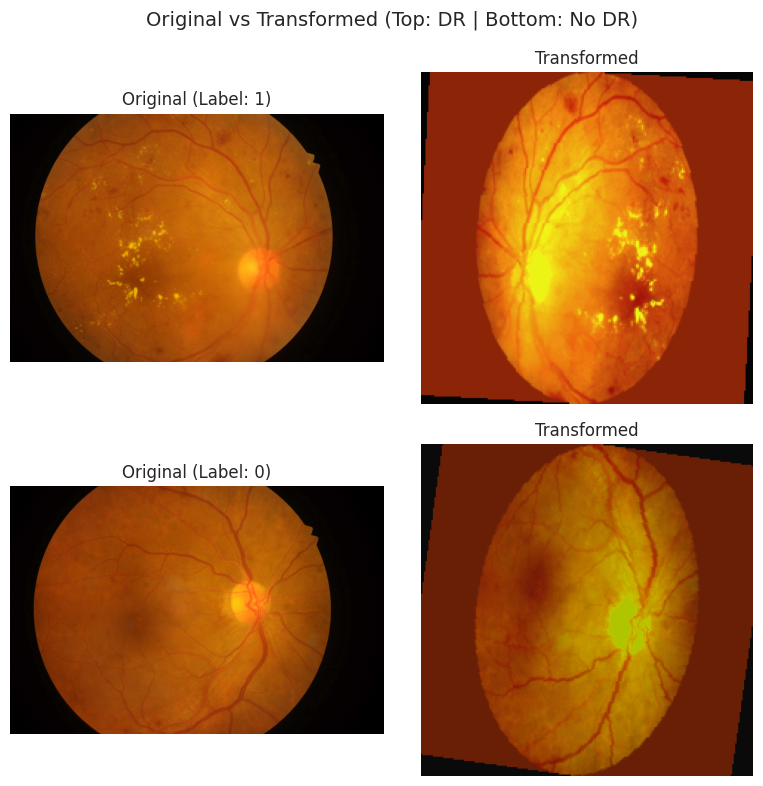

In [13]:
raw_dataset = DRDataset(
    img_dir=TRAIN_IMAGES_DIR,
    csv_file=TRAIN_LABELS_DIR,
    transform=None
)

# idx 0 = DR, idx 117 = No DR
indices = [0, 117]

def denormalize(tensor_img, mean=[0.5]*3, std=[0.2]*3):
    for t, m, s in zip(tensor_img, mean, std):
        t.mul_(s).add_(m)
    return tensor_img

# Convert tensor to PIL
to_pil = transforms.ToPILImage()

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Original vs Transformed (Top: DR | Bottom: No DR)', fontsize=14)

for row_idx, idx in enumerate(indices):
    original_img, label = raw_dataset[idx]
    transformed_img, _ = full_dataset[idx]
    transformed_img = denormalize(transformed_img.clone()).clamp(0, 1)

    # Left: Original
    axes[row_idx, 0].imshow(original_img)
    axes[row_idx, 0].set_title(f"Original (Label: {int(label.item())})")
    axes[row_idx, 0].axis("off")

    # Right: Transformed
    axes[row_idx, 1].imshow(to_pil(transformed_img))
    axes[row_idx, 1].set_title("Transformed")
    axes[row_idx, 1].axis("off")

plt.tight_layout()
plt.show()

# **Create the Validation Set**

In [14]:
torch.manual_seed(42)
from torch.utils.data import random_split
dataset_size = len(full_dataset)
train_split = 0.8
train_size = int(train_split * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# **Create the Training/Validation Batches**

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# **Create the Testing Batches**

In [17]:
TEST_IMAGES_DIR = 'testing_images'
TEST_LABELS_DIR = 'testing_labels.csv'

test_dataset = DRDataset(
        img_dir=TEST_IMAGES_DIR,
        csv_file=TEST_LABELS_DIR,
        transform=test_transform
    )

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Testing size:", len(test_dataset))

Testing size: 103


**Image Classification Model #1 - Convolutional Neural Network (CNN)**

**Building the CNN Architecture  **

In [18]:
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

class SimpleDRCNN(nn.Module):
  def __init__(self):
    super(SimpleDRCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(64 * 28 * 28, 128)
    self.fc2 = nn.Linear(128, 1)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)

    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = torch.sigmoid(self.fc2(x)).squeeze(1)

    return x

cnn_model = SimpleDRCNN()

# **Move device to GPU**

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_model.to(device)
print(device)

cuda


# **Initialize the Loss Function and Optimizer**

Since there is moderate class imbalance, we'll use the weight parameter in the BCELoss loss function to manually rescale the weights given to each image's loss based on its class.


*   If the model makes an error on the minority class, the loss is ~2x more costly than making errors on the majority class.




In [20]:
import torch.optim as optim
torch.manual_seed(42)

weight = torch.tensor([279/134]).to(device)
criterion = nn.BCELoss(weight=weight)

optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001)

print("Loss function:", criterion)
print("Optimizer:", optimizer)


Loss function: BCELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


# **Training Loop**

In [21]:
torch.manual_seed(42)

train_losses = []
val_losses = []

num_epochs = 7

for epoch in range(num_epochs):
  total_train_loss = 0
  total_val_loss = 0

  cnn_model.train()
  for images, labels in train_dataloader:
    #Training
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = cnn_model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()

    #Validation
  cnn_model.eval()
  with torch.no_grad():
    for images, labels in val_dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = cnn_model(images)
      val_loss = criterion(outputs, labels)
      total_val_loss += val_loss.item()

  # Calculate average losses
  avg_train_loss = total_train_loss / len(train_dataloader)
  avg_val_loss = total_val_loss / len(val_dataloader)

  # Save the average training and validation losses
  train_losses.append(avg_train_loss)
  val_losses.append(avg_val_loss)

  print(f"Epoch [{epoch+1}/{num_epochs}]: Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")





Epoch [1/7]: Training Loss: 1.3027 - Validation Loss: 1.2434
Epoch [2/7]: Training Loss: 1.3348 - Validation Loss: 1.1245
Epoch [3/7]: Training Loss: 1.2942 - Validation Loss: 1.1934
Epoch [4/7]: Training Loss: 1.2420 - Validation Loss: 1.1491
Epoch [5/7]: Training Loss: 1.2545 - Validation Loss: 1.1497
Epoch [6/7]: Training Loss: 1.1403 - Validation Loss: 1.0839
Epoch [7/7]: Training Loss: 1.1819 - Validation Loss: 1.1450


# **Visualize the Training and Validation Loss**

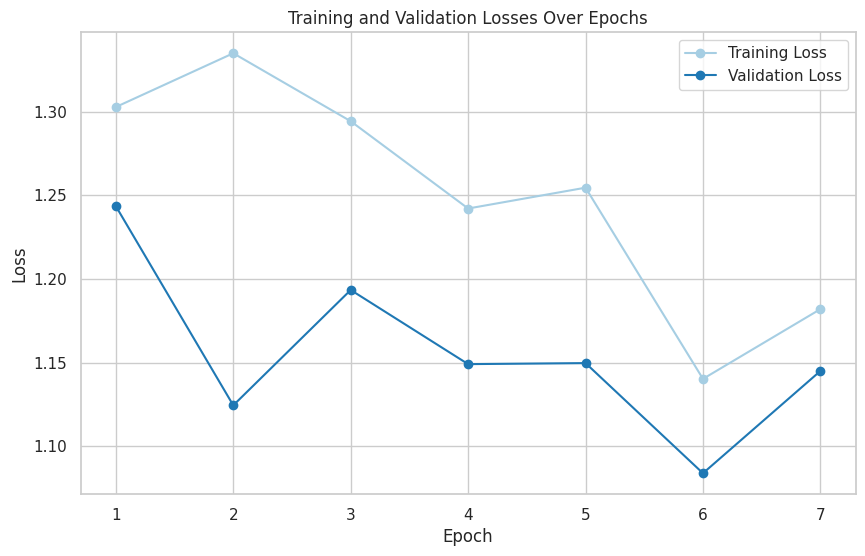

In [22]:
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

The training and validation losses gradually decrease during the training epochs, which is generally a good sign that the model is learning from the training data.

However, there is a clear divergence after epoch 7, where the validation loss becomes larger than the training loss, which is a clear sign of overfitting. More evidence to support this is that the model continues to improve on the training set but increasingly performs worse on the validation set, suggesting that it is memorizing the training set rather than learning generalizable patterns to detect diabetes retinopathy.

**Areas For Improvement**


*   Re-train the CNN for seven epochs, where the validation loss reaches its minimum value
*   Modify the CNN architecture

    *   Change the number of neurons in each layer
    *   Change the kernel size
    *   Add new layers like dropout or batch normalization






# **Testing Set Evaluation**

In [23]:
import numpy as np

test_pred_probs = []
test_pred_labels = []

cnn_model.eval()
with torch.no_grad():
  for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    #Outputs already has sigmoid activation
    outputs = cnn_model(images)
    test_pred_probs.extend(outputs.cpu().numpy())

    pred_labels = (outputs >= 0.5).int()
    test_pred_labels.extend(pred_labels.cpu().numpy())

test_pred_probs = np.array(test_pred_probs)
test_pred_labels = np.array(test_pred_labels)


print("First image predicted probability:", test_pred_probs[0])
print("First image predicted label:", test_pred_labels[0])
print("First image actual label:", labels[0].item())

First image predicted probability: 0.15048173
First image predicted label: 0
First image actual label: 0.0


In [25]:
from sklearn.metrics import classification_report

test_true_labels = []

for _, labels in test_dataloader:
  test_true_labels.extend(labels.numpy())

dr_classes = ['No DR', 'DR']
report = classification_report(y_true=test_true_labels,
                               y_pred=test_pred_labels,
                               target_names=dr_classes)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       No DR       0.24      0.12      0.16        34
          DR       0.65      0.81      0.72        69

    accuracy                           0.58       103
   macro avg       0.44      0.46      0.44       103
weighted avg       0.51      0.58      0.54       103



# **Key Insights (CNN)**
The baseline CNN for detecting diabetic retinopathy achieved an overall accuracy of 58%. This means that the model correctly predicted 58% of all images in the testing set, which can be considered modest, but there is certainly room for improvement. Let's take a look at the performance for each class.

**Class 0 Performance (No DR)**

Within patients who do not have diabetic retinopathy:


*   A precision of 0.24 means that when the CNN predicted a patient did not have DR, it was only correct 24% of the time
*   A recall of 0.12 means that the CNN correctly identified only 12% of patients without DR


*   An F1-score of 0.16 suggests a poor balance between the precision and recall score for class 0

**Class 1 Performance (DR)** Within patients who do have diabetic retinopathy:


*   A precision of 0.65 means that when the CNN predicted a patient with DR, it was correct 65% of the time

*   A recall of 0.81 means that the CNN correctly identified 81% of patients with DR
*   An F1-score of 0.72 suggests a decent balance between recall and precision for class 1

The higher scores for patients with DR (class 1) are most likely due to model bias, as a result of the class imbalance in the training data, which consists mostly of patients with DR. This is evidence that the model is biased towards predicting patients with DR and that it hasn't fully learned meaningful and generalizable patterns. We may need to rethink our class imbalance strategy in order to improve CNN's performance.







In [26]:
prediction_dist = pd.Series(test_pred_labels).value_counts()
print(prediction_dist)

1    86
0    17
Name: count, dtype: int64


### 🔍 Image Classification Model #2 - Vision Transformer (ViT)

We'll now train a more advanced image classification model: the **Vision Transformer (ViT)**.

We'll use a standard pre-trained ViT model from Hugging Face:  
👉 [ViT-Base Patch16-224](https://huggingface.co/google/vit-base-patch16-224)


In [27]:
import torch
import numpy as np
import random

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# For CUDA
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor

model_name = "google/vit-base-patch16-224"

vit_model = ViTForImageClassification.from_pretrained(model_name,
                                                      #num_labels=2,
                                                      ignore_mismatched_sizes=True)
processor = ViTImageProcessor.from_pretrained(model_name)

vit_model.classifier = nn.Linear(vit_model.classifier.in_features, 2)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)
print(device)

cuda


# **ViT Training/Testing Transformation Pipeline**

In [30]:
from torchvision import transforms

vit_train_transform = transforms.Compose([
    RetinalCenterCrop(),
    SimpleCLAHE(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

vit_test_transform = transforms.Compose([
    RetinalCenterCrop(),
    SimpleCLAHE(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

# **Create the ViT Training/Validation Batches**

In [31]:
TRAIN_IMAGES_DIR = 'training_images'
TRAIN_LABELS_DIR = 'training_labels.csv'

full_dataset = DRDataset(
        img_dir=TRAIN_IMAGES_DIR,
        csv_file=TRAIN_LABELS_DIR,
        transform=vit_train_transform
    )

In [32]:
from torch.utils.data import random_split

dataset_size = len(full_dataset)

train_split=0.8
train_size = int(train_split * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

In [33]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# **Create the ViT Testing Batches**

In [34]:
TEST_IMAGES_DIR = 'testing_images'
TEST_LABELS_DIR = 'testing_labels.csv'

test_dataset = DRDataset(
        img_dir=TEST_IMAGES_DIR,
        csv_file=TEST_LABELS_DIR,
        transform=vit_test_transform
    )

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print("Testing size:", len(test_dataset))

Testing size: 103


# **Freeze and Unfreeze Layers**

1.   Freeze all layers
2.   Unfreeze the last two transformer layers

1.   Unfreeze the classification head




In [35]:
import torch.optim as optim
import torch.nn as nn

for param in vit_model.parameters():
  param.requires_grad = False


for param in vit_model.classifier.parameters():
  param.requires_grad = True

for param in vit_model.vit.encoder.layer[-1:].parameters():
    param.requires_grad = True


# **Initialize Loss Function and Optimizer**
We'll use the Adam variant AdamW with decay and apply different learning rates to each layer to be fine-tuned.

We'll also use the weight parameter in the CrosEntropyLoss loss function to account for class imbalance.

In [36]:
# AdamW optimizer with weight decay
optimizer = optim.AdamW([
    {'params': vit_model.classifier.parameters(), 'lr': 1e-3, 'weight_decay':0.01},
    {'params': vit_model.vit.encoder.layer[-1].parameters(), 'lr': 1e-4, 'weight_decay':0.01}])

# Calculate class weights based on inverse frequency
class_counts = torch.tensor([134, 279], dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights * 2
class_weights = class_weights.to(device)

# Use weighted CrossEntropyLoss loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# **Fine-Tuning Loop**

In [37]:
torch.manual_seed(42)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 6
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0
    train_correct = 0
    train_total = 0
    val_correct = 0
    val_total = 0

    # Training
    vit_model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = vit_model(pixel_values=images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    vit_model.eval()
    with torch.no_grad():
      for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device).long()

        outputs = vit_model(pixel_values=images).logits
        val_loss = criterion(outputs, labels)

        total_val_loss += val_loss.item()
        preds = outputs.argmax(dim=1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total


    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}]: Training Loss: {avg_train_loss:.4f} - Training Accuracy: {train_accuracy:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/6]: Training Loss: 0.6766 - Training Accuracy: 0.5485 - Validation Loss: 0.6306 - Validation Accuracy: 0.7349
Epoch [2/6]: Training Loss: 0.5431 - Training Accuracy: 0.6939 - Validation Loss: 0.4481 - Validation Accuracy: 0.7711
Epoch [3/6]: Training Loss: 0.4728 - Training Accuracy: 0.7727 - Validation Loss: 0.5294 - Validation Accuracy: 0.7229
Epoch [4/6]: Training Loss: 0.3941 - Training Accuracy: 0.8455 - Validation Loss: 0.4894 - Validation Accuracy: 0.7952
Epoch [5/6]: Training Loss: 0.3853 - Training Accuracy: 0.8000 - Validation Loss: 0.4794 - Validation Accuracy: 0.8072
Epoch [6/6]: Training Loss: 0.3235 - Training Accuracy: 0.8303 - Validation Loss: 0.3567 - Validation Accuracy: 0.8795


# **Testing Set Evaluation**

In [38]:
vit_model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device).long()

        outputs = vit_model(pixel_values=images).logits
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

acc = correct / total
print(f"\nTest Accuracy: {acc:.4f}")


Test Accuracy: 0.8058


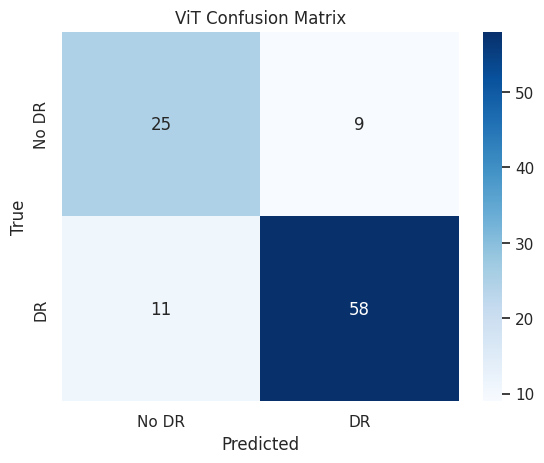

              precision    recall  f1-score   support

       No DR       0.69      0.74      0.71        34
          DR       0.87      0.84      0.85        69

    accuracy                           0.81       103
   macro avg       0.78      0.79      0.78       103
weighted avg       0.81      0.81      0.81       103



In [39]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class_names=["No DR", "DR"]
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ViT Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))

# **Key Insights (ViT)**
The fine-tuned vision transformer for detecting diabetic retinopathy achieved an overall accuracy of 81%. This means that the model correctly predicted 82% of all images in the testing set, which can be considered decent and a significant improvement over the CNN, which achieved an overall accuracy of only 58%.

Let's take a look at the performance for each class.


---



**Class 0 Performance (No DR)**

Within patients who do not have diabetic retinopathy: A precision of 0.69 means that when the ViT predicted a patient did not have DR, it was correct 69% of the time, which is much better than the CNN, which had a precision of 0.24.



*   A recall of 0.74 means that the ViT correctly identified only 74% of patients without DR, though this is much better than the CNN, with a recall of 0.12
*   An F1-score of 0.71 suggests a good balance between the precision and recall score for class 0, and is significantly better than the CNN F1-score of 0.16


---



**Class 1 Performance (DR)** Within patients who do have diabetic retinopathy:



*   A precision of 0.87 means that when the CNN predicted a patient with DR, it was correct 87% of the time, which is much better than the CNN's precision of 0.65
*   A recall of 0.84 means that the CNN correctly identified 84% of patients with DR, which is better than the CNN recall of 0.81

*   An F1-score of 0.85 suggests a great balance between recall and precision for class 1, and is improved over the CNN F1-score of 0.72


---



**Key Insights (Overall)**

Overall, the ViT significantly outperformed the CNN across all metrics. Unlike CNN, whose bias to overpredict the majority class (patients DR) results in an inflated recall score, the ViT appears more balanced and performs well across both classes. Furthermore, the better F1-scores for the ViT in both classes suggest that the ViT has better learned generalizations than the CNN to classify diabetes retinopathy within the images.

From a clinical perspective, the ViT is significantly better than the CNN. The ViT's balanced performance makes it a more reliable model regarding safety and decision-making.



*   False negatives (missed DR) can delay critical care to patients in need
*   False positives (misdiagnosing No DR as DR) can cause unnecessary anxiety, referrals, and resource strain among patients
A clinically useful model must balance high sensitivity (recall) and high specificity (precision) across both classes, which the ViT offers more than the CNN.


---


**Conclusion**

In conclusion, our project successfully fine-tuned a vision transformer to classify retinal fundus images for diabetic retinopathy with decent performance. Compared to a baseline CNN, the vision transformer demonstrated significantly better generalization power across both classes, achieving a higher balance of precision and recall, especially for the minority class (No DR).

Future work could explore using different model architectures, using specialized pre-trained vision transformers, dataset balancing techniques, collecting more data, and applying more rigorous testing/validation strategies. Remember, these models are not intended for real-world medical imaging applications and should not be relied upon for diagnosing, predicting, or managing diabetes retinopathy or any other health outcomes. Any health-related decisions should always be made with the guidance of a qualified healthcare professional!






